# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (2da entrega)

## Fecha de entrega

*Ingresar fecha*

## Integrantes

* <Nombre, Apellido>
* <Nombre, Apellido>
* <Nombre, Apellido>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la función de ejemplo (`ruidoRosa_voss`)(1er entrega).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser grabadas en formato .wav en la misma función que las genera.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sounddevice as sd
import pandas as pd
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
import soundfile as sf

from tkinter import Tk, filedialog
import shutil
from IPython.display import clear_output

import sys
sys.path.append('../')
from util.functions import plot, askBooleanInput, plotWAV, getWAVData, plotDataFrame, createFigure, getDataFrameData, generarSineSweepYFiltroInverso, getWAVDataNon16Bit

fs = 44100
t60 = [2.5, 2.4, 2.2, 2.0, 1.8, 1.6, 1.4, 1.2, 1.0, 0.8]


## Descargar dataset
El objetivo es tener archivos para validar el software creado , para lo cual es necesario contar con la información y los datos de la medición.

### 1. Respuestas al impulso: 
**Consigna:** Descargar **al menos dos** respuestas al impulso (RI o en ingles IR, Impulse Responses) de dos recintos distintos del siguiente [link](https://www.openair.hosted.york.ac.uk/?page_id=36) y toda la información relevante de la medición, ademas de los resultados de los parametros acústicos calculados (para luego comparar). También se pueden usar los archivos dispuestos en el Drive de la asignatura. 

### 2. Sine sweep logarítmico + filtro inverso: 
**Consigna:** Descargar **al menos un** sine sweep con su respectivo filtro inverso. Una posibildiad es usar los archivos dispuestos en el GDrive de la asignatura. Para generar el filtro inverso usar la info brindada por el informe técnico en la misma carpeta de los archivos. 

## Función de carga de archivos de audio

**Consigna:** realizar una función que permita cargar archivos de audio, en lo posible \*.wav, por ejemplo los archivos anteriormente descargados. Contemplar el ingreso de más de un archivo de audio, por tipo.

In [37]:

def saveFiles(files=[], visualize=False):
    """
    
    Creates a list containing .wav file routes provided by the user through the file explorer.

    Parameters:
        files (list): A previous list of files to add routes into.
        visualize (boolean): A value to decide if the files should be plotted.
        save (boolean): A value to decide if the files should be saved to media/save_files.

    Returns:
        list: The list of the selected file routes.

    """                                
    clear_output()
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    files.append(filedialog.askopenfilename(filetypes=[("wav files", "*.wav")]))
    anotherFile = askBooleanInput("Do you wish to add another file?")
    if anotherFile:
        saveFiles(files)

    if visualize:
        for file in files:
            plotWAV(file, title=file, xLabel="X-Axis", yLabel="Y-Axis")
            
    return files


Llamar a la función con uno de los ejemplos anteriormente descargados y usar la función de visualización de la 1er entrega.

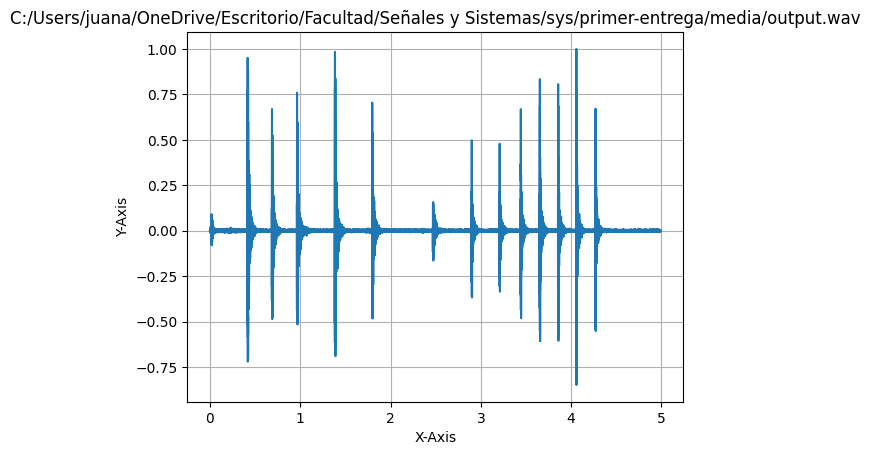

['C:/Users/juana/OneDrive/Escritorio/Facultad/Señales y Sistemas/sys/primer-entrega/media/output.wav']

In [38]:
saveFiles(files=[], visualize=True)

## Función de sintetización de respuesta al impulso

**Consigna:** realizar una función para sintetizar una respuesta al impulso. La misma recibira como parametro el $T60$ que se desea obtener, y deberá sintetizar una respuesta al impulso considerando las frecuencias centrales de banda de octava y tercio de octava como establece la norma IEC61260 (IEC61260,1995). La siguiente ecuación define una RI, para una frecuencia central $f_{i}$:

\begin{equation}
y_{i}=A_{i}e^{-\tau_it}\cos(2πf_{i}t)
\tag{6}
\end{equation}

donde $A_{i}$ es el coeficiente de amplitud para esa $f_{i}$(puede ser 1), y  $π_{i}$ define el decaimiento exponencial en función de $T_{60_i}$ (tiempo de reverberación) para una frecuencia $f_{i}$.

\begin{equation}
\tau_i=-\frac{ln(10^{-3})}{T_{60_i}}
\tag{7}
\end{equation}

La suma de varias frecuencias centrales $f_{i}$ se define como:
\begin{equation}
  y=\sum_{y=1}^{n}y_{i}
\tag{8}
\end{equation}

Con $n$ la cantidad de frecuencias centrales $f_{i}$ del filtro. La funcion debe recibir el tiempo de reverberacion para cada frecuencia, y devolver la respuesta al impulso correspondiente como un archivo de audio .wav. Al momento de definir la función, buscar la forma de que la misma permita varios $T60_i$ para cada frecuencia. 

> Con esta funcion se busca obtener un archivo de audio de valores de $T60_i$ conocidos que permita probar el software.

In [2]:
def synthesizeImpulseResponse(t60, duration = 3, band="octave", a=1, fs=44100):

    """
        
        Synthesizes an impulse response based on a T60 values list for corresponding frequencies. It will also create the wav file in media/synthesized-impulse-response.wav.

        Parameters:
            t60 (list): The list of T60 values for each frequency, following the same order as the frequencies by octave or thirds.
            duration (float): The duration of the impulse response.
            band (string): A value that specifies if the impulse response will be synthesized based on a T60 for each frquency in a list of frequencies by octave or by thirds.
            a (float): Amplitude coefficient for each impulse response that compose the final impulse response. By default its value is 1, which will be interpreted as a 1 for all frequencies.
            fs (int): The sampling rate.

        Returns:
            list: The impulse response.
            list:  The time vector.

        """  

    centralFrequencies = [31.5,63,125,250,500,1000,2000,4000,8000,16000] if band == "octave" else [25,31.5,40,50,63,80,100,125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000,10000,12500,16000,20000]
    if a == 1:
        a = np.ones(len(centralFrequencies))
    if len(a) != len(centralFrequencies) != len(t60):
        print("The length of the list of amplitude coefficients, central frequencies, and T60 values dont match. Please provide ones that do.")
        return
    t60 = np.array(t60)
    time = np.linspace(0, duration, duration*fs)
    impulseResponses = []
    for i in range(len(centralFrequencies)):
        tau = -np.log(10**(-3)) / t60[i]
        impulseResponses.append(a[i]*np.exp(-tau*time)*np.cos(2*np.pi*centralFrequencies[i]*time))

    impulseResponse = sum(impulseResponses)
    impulseResponse = impulseResponse / np.max(np.abs(impulseResponse))
    wavfile.write("media/synthesized-impulse-response.wav", fs, np.int16(impulseResponse * 32767))
    return impulseResponse, time

Llamar a la función con un vector que contega varios $T60$ para las cada frecuencias centrales $f_{i}$.

In [3]:
impulseResponse, time = synthesizeImpulseResponse(t60)

Llamar la función de visualizar el dominio temporal, de la entrega anterior.

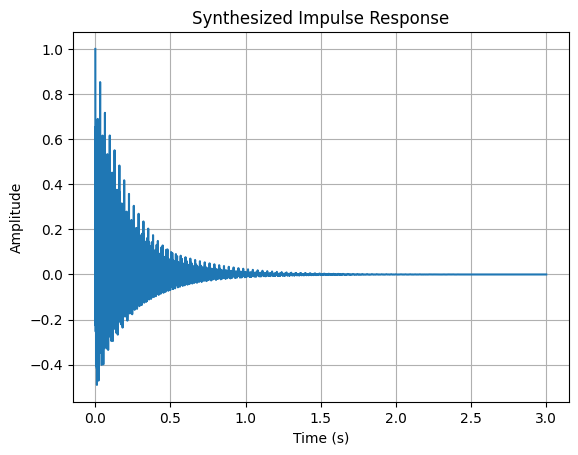

In [4]:
plot(time, impulseResponse, "Time (s)", "Amplitude", "Synthesized Impulse Response")

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

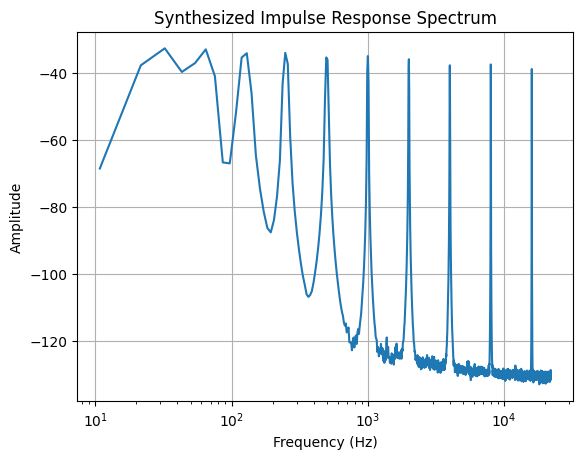

In [5]:
df = pd.read_csv("media/spectrum-synthesized-impulse-response.txt", sep='\t', header=0)
plot(df.iloc[:, 0], df.iloc[:, 1], "Frequency (Hz)", "Amplitude", "Synthesized Impulse Response Spectrum", "log")

Reproducir señal resultante.

In [6]:
sd.play(impulseResponse)
sd.wait()

Comentar sobre el resultado obtenido, ¿Es una buena aproximación? ¿Qué aspectos estamos dejando de lado en esta sintetización, que en un caso real estan presentes?.

Simplemente escuchando el archivo de audio es notorio el sonido poco natural que tiene. Concluimos en base a esto que este método, aunque útil para realizar pruebas, no es una buena aproximación de la respuesta al impulso de ninguna sala sobre la cual solo conocemos sus T60 para cada frecuencia determinada por la norma IEC61260. Esto se debe a que una sala no estará solamente caracterizada por dicho parametro. La forma de la curva del tiempo de caida puede ser una de ellas. La norma ISO3382 específica que sus curvas de de caida deben ser aproximadamente lineales:

"In order to specify a reverberation time, the decay curves shall follow approximately a straight line. If the
curves are non-linear this may indicate a mixture of modes with different reverberation times and thus the
result may be unreliable."

Esto alude a la alinealidades presentes en el sistema que esta siendo medido. Podemos interpretar que remover dichas linealidades en su totalidad sintetizando una respuesta al impulso dará un resultado alejado de la realidad y poco natural.

Otros factores que tambien pueden tener influencia podrian ser el volumen de la sala y sus dimensiones, el piso de ruido, etc. 

## Función obtener respuesta al impulso

**Consigna:** realizar una función que permita obtener la respuesta al impulso en formato de señal de audio .wav, a partir del sinesweep logarítmico grabado y el filtro inverso generado utilizando el siguiente método: 

Supongamos que un recinto es excitado por una señal sinesweep logarítmica $x(t)$ y captada por un micrófono $y(t)$ y buscamos la RI del recinto $h(t)$, lo anterior se expresa de la siguiente manera:

\begin{equation}
y(t)=x(t)*h(t)
\tag{9}
\end{equation}

Para un sine sweep lineal (que no es nuestro caso) el problema es sencillo, pero en nuestro caso (sine sweep logarítmico) requiere trabajar un poco respecto $x(t)$ para obtener la siguiente expresión:

\begin{equation}
h(t) = F^{-1}[H(jw)]=F^{-1}[Y(jw)K(jw)]
\tag{10}
\end{equation}

Recordar que $k(t)$ es el filtro inverso (ecu.5) y $K(jw)$ su respectiva transformada de fourier. De esta manera se obtiene la respuesta al impulso buscada.

> El desarrollo matemático de la anterior expresión se encuentra en el [Anexo I - Obtener la respuesta al impulso a partir de un sine sweep](../consigna_TP_matlab.pdf) (p.14) del instructivo para Matlab del TP.

In [10]:
def getImpulseResponse(sineSweep, inverseFilter):

    """

    Obtains the impulse response through the convolution of a sine sweep and its inverse filter, with the method proposed by Angelo Farina.

    Parameters:
        sineSweep (list): The sine sweep.
        inverseFilter (list): The inverse filter of the sine sweep.

    Returns:
        list: The impulse response.

    """ 

    impulseResponse = fftconvolve(sineSweep, inverseFilter)
    halfIndex = len(impulseResponse) // 2
    impulseResponse = impulseResponse[halfIndex:]
    impulseResponse = impulseResponse / np.max(np.abs(impulseResponse))

    return impulseResponse


Llamar a la función con un sine sweep y su respectivo filtro inverso creados con la función de la primer entrega (**no** los descargados).

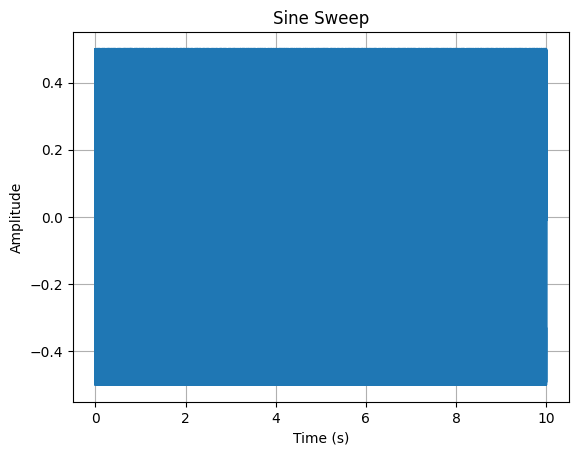

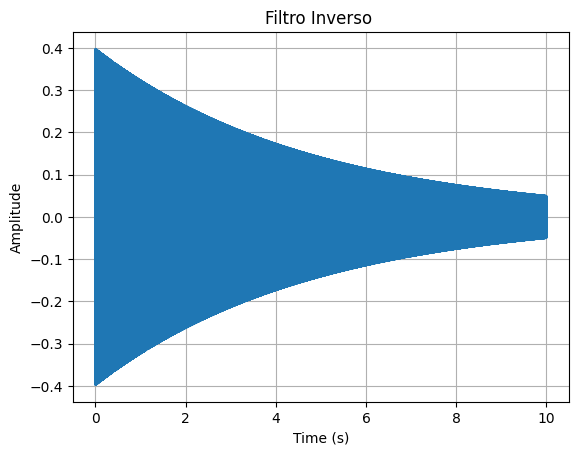

In [14]:
#sineSweep, inverseFilter, time = generarSineSweepYFiltroInverso(20, 4000, 5)

sineSweep, sampleRatesineSweep = sf.read("../primer-entrega/media/sine-sweep.wav")
inverseFilter, sampleRateinverseFilter = sf.read("../primer-entrega/media/filtro-inverso.wav")

time = np.linspace(0, len(sineSweep) / sampleRatesineSweep, len(sineSweep))

plot(time, sineSweep, title="Sine Sweep")
plot(time, inverseFilter, title="Filtro Inverso ")

impulseResponse = getImpulseResponse(sineSweep, inverseFilter)

Visualizar la señal con la función creada en la primer entrega.

<function matplotlib.pyplot.show(close=None, block=None)>

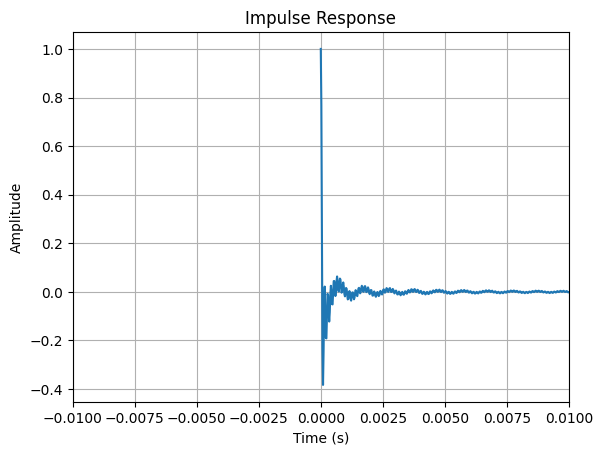

In [15]:
fig, ax = createFigure(time, impulseResponse , "Time (s)", "Amplitude", "Impulse Response")
ax.set_xlim([-0.01, 0.01])

plt.show

Reproducir señal resultante.

In [28]:
sd.play(impulseResponse)

Comentar sobre el resultado obtenido. ¿Qué es lo que se esta escuchando? Realizar el mismo procedimiento con la señal descargada y el filtro inverso generado (para dicho sine sweep)

Dado que se utilizó el mismo sine sweep con el que se generó el filtro inverso, no el sine sweep emitido y grabado en un recinto, la respuesta al impulso obtenida estaría caracterizando a un recinto cuyo tiempo de reverbreación es nulo, y no modifica en su totalidad a cualquier sonido emitido dentro de el. En otras palabras, esta carente de cualquier tipo de identidad y es una concepción totalmente irreal.

c:\Users\juana\OneDrive\Escritorio\Facultad\Señales y Sistemas\sys\segunda_entrega\..\util\functions.py:68: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WAV = wavfile.read(route)


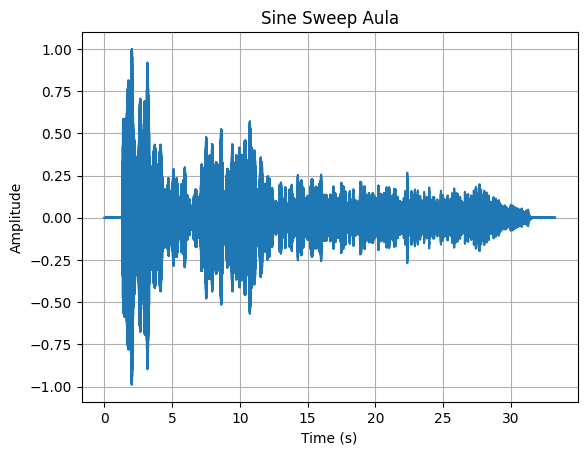

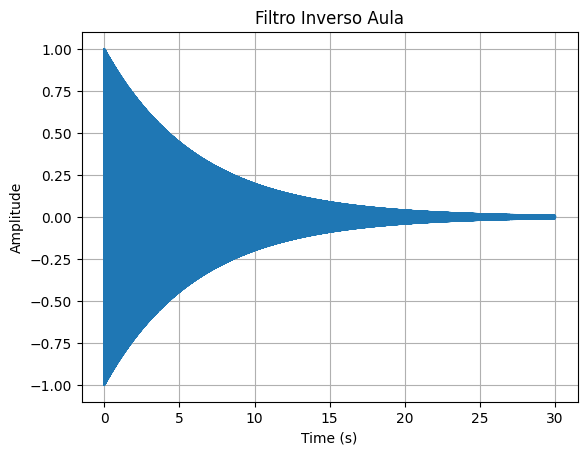

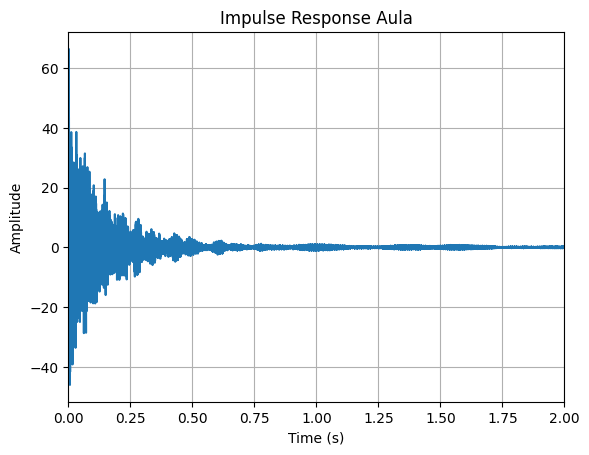

In [29]:
sineSweepAula, timeSineSweepAula = getWAVData("media/Toma_n3_e-03_aula.wav")
inverseFilterAula, timeInverseFilterAula = getWAVData("media/filtro_inverso_aula.wav")

plot(timeSineSweepAula, sineSweepAula, title="Sine Sweep Aula")
plot(timeInverseFilterAula, inverseFilterAula, title="Filtro Inverso Aula")

impulseResponseAula = getImpulseResponse(sineSweepAula, inverseFilterAula)

fix, ax = createFigure(np.linspace(0, len(impulseResponseAula) / fs, len(impulseResponseAula)), impulseResponseAula, "Time (s)", "Amplitude", "Impulse Response Aula")
ax.set_xlim([0, 2])
plt.show

sd.play(impulseResponseAula / np.max(np.abs(impulseResponseAula)))

Mencionar aspectos que diferencian los impulso generados en esta función, con los sintetizados.

Las diferencias entre estas dos respuestas al impulso (la sintetizada y la del aula) son evidentes tanto graficamente como de forma audible. La respuesta al impulso del aula suena real y podriamos imaginar que es como se escucharia emitir un impulso dentro del recinto, a diferencia de la RI sintetizada, que esta completamente vacía de carácter. Esto se refleja en la representación gráfica de ambas, donde la sintetizada es simplemente un valor único en el timepo 0, representando que el "recinto sintetizado" reproduce exactamente lo emitido dentro de este, y la RI del aula muestra una caída característica del nivel a lo largo del tiempo.

## Función filtros norma IEC61260

**Consigna**: Realizar una función que filtre todas las señales en octavas y tercio de octava según la norma IEC61260, con el objetivo de calcular los parámetros acústicos discriminando las frecuencias. 

Para lo cual utilizar las funciones del modulo [signals de scipy](https://docs.scipy.org/doc/scipy/reference/signal.html). Se adjunta el código capaz de calcular los coeficientes del filtro y aplicarlos a una señal. La función debe completarse con el código necesario para que este proceso se repita para cada una de las frecuencias centrales determinadas en la norma. Así mismo, el primer argumento de la función [iirfilter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirfilter.html) determina el grado del filtro. Evaluar el valor del mismo para que la frecuencia central de la banda coincida con las especificadas en la norma.

> Para ver una introducción breve a la implementación de filtros, usar el siguiente [documento](https://github.com/maxiyommi/signal-systems/blob/master/material_extra/Filtros/intro_filtros.ipynb).

In [30]:
def filterSignalByBands(audioData, band="octave"):

    """
    
    Filters a signal with a bandpass filter with different central frequencies, either by octave or thirds.

    Parameters:
        audioData(list): The audio signal to be filtered.
        band (string): The central frequencies, by default it is the central frequencies by octave band according to IEC61260 from 125Hz to 8000Hz.

    Returns:
        list: The list of filtered signals.
    
    """ 

    signals = []
    centralFrequencies = [125,250,500,1000,2000,4000,8000] if band == "octave" else [125,160,200,250,315,400,500,630,800,1000,1250,1600,2000,2500,3150,4000,5000,6300,8000]

    for frequency in centralFrequencies:
        #Octava - G = 1.0/2.0 / 1/3 de Octava - G=1.0/6.0
        G = 1.0/2.0 if band == "octave" else 1.0/6.0
        factor = np.power(2, G)
        centerFrequency_Hz = frequency

        #Calculo los extremos de la banda a partir de la frecuencia central
        lowerCutoffFrequency_Hz = centerFrequency_Hz / factor
        upperCutoffFrequency_Hz = centerFrequency_Hz * factor

        #print('Frecuencia de corte inferior: ', round(lowerCutoffFrequency_Hz), 'Hz')
        #print('Frecuencia de corte superior: ', round(upperCutoffFrequency_Hz), 'Hz')

        # Extraemos los coeficientes del filtro 
        #b,a = signal.iirfilter(4, [2*np.pi*lowerCutoffFrequency_Hz,2*np.pi*upperCutoffFrequency_Hz],
        #                            rs=60, btype='band', analog=True,
        #                            ftype='butter')

        # para aplicar el filtro es más óptimo
        sos = signal.iirfilter(4, [lowerCutoffFrequency_Hz,upperCutoffFrequency_Hz],
                                    rs=60, btype='band', analog=False,
                                    ftype='butter', fs=fs, output='sos')
        #w, h = signal.freqs(b,a)

        # aplicando filtro al audio
        signals.append(signal.sosfilt(sos, audioData))
    
    return signals

Llamar a la función con alguna RI generada anteriormente.

In [31]:
impulseResponse, time = getWAVData("media/synthesized-impulse-response.wav")
filteredImpulseResponseByOctaveList = filterSignalByBands(impulseResponse)

wavfile.write("media/filteredImpulseResponse500hz.wav", 44100, np.int16(filteredImpulseResponseByOctaveList[2] * 32767))

Graficar el dominio espectral del resultado en una banda, utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

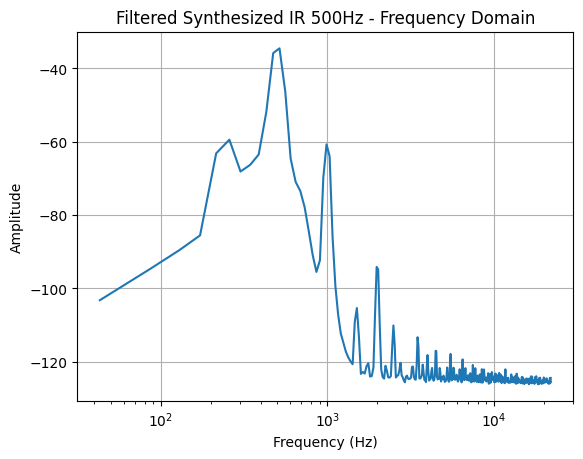

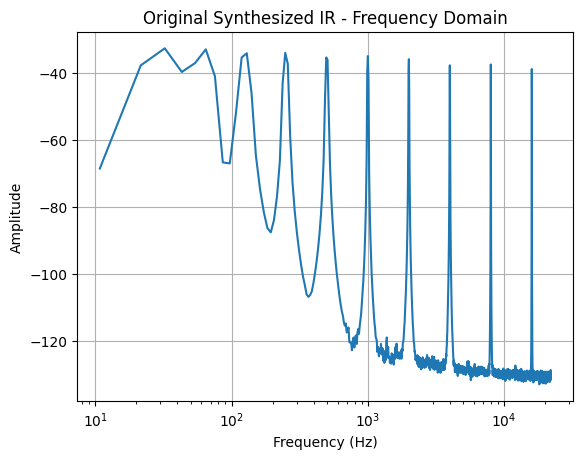

In [32]:
plotDataFrame("media/spectrum-filtered-synthesized-impulse-response500hz.txt", "Frequency (Hz)", "Amplitude", "Filtered Synthesized IR 500Hz - Frequency Domain")
plotDataFrame("media/spectrum-synthesized-impulse-response.txt", "Frequency (Hz)", "Amplitude", "Original Synthesized IR - Frequency Domain")


¿El resultado es el esperado? ¿Cumple con los requerimientos de la normativa?

Consideramos que tanto de forma audible como de forma gráfica, el filtro está funcionando correctamente. El archivo WAV generado demuestra la atenuación de la frecuencias fuera de la banda de paso de forma clara para todas las frecuencias centrales. Luego, se puede observar en el espectro del filtro de 500hz como frecuencia central, que aquellas frecuencias por fuera del rango 354Hz - 707Hz son progresivamente atenuadas, particularmente aquellas frecuencias altas como el pico en aproximadamente 7500Hz y 16000Hz en el espectro original. 

## Función conversión a escala logarítmica normalizada
Para visualizar correctamente la señal es necesario realizar una función que convierta la respuesta al impulso en escala logarítmica, utilizando la siguiente expresión:

\begin{equation}
    R(t) = 20\log_{10}\frac{A(t)}{A(t)_{max}}
\tag{11}
\end{equation}

Donde $A(t)$ es la señal que deseamos transformar de escala. **Consigna:** crear una función que convierta a escala logarítmica la RI que ingresa y devuelva un array con la señal resultante.

In [7]:
def logarithmicScaleConversion(signal):
    """

    Converts a signals vertical axis into logarithmic scale.

    Parameters:
        signal (list): The signal to be converted.

    Returns:
        list: The converted signal.

    """ 
    signal = np.where(signal == 0, 1e-10, signal)
    return 20 * np.log10(np.abs(signal/np.max(signal)))

Llamar a la función con alguna de las señales generadas anteriormente.

In [10]:
impulseResponse, time = synthesizeImpulseResponse(t60)

impulseResponseInLogScale = logarithmicScaleConversion(impulseResponse)

Visualizar la señal con la función creada en la primer entrega.

<function matplotlib.pyplot.show(close=None, block=None)>

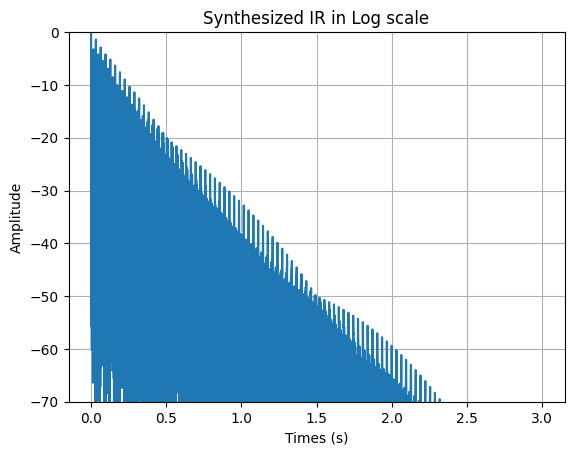

In [11]:
fig, ax = createFigure(time, impulseResponseInLogScale, title="Synthesized IR in Log scale") # Entiendo que no le pongo scale
ax.set_ylim([-70, 0])
plt.show

### Informe preliminar (opcional)
Realizar un informe preliminar en formato UNTREF para memorias cuatrimestrales (disponible en el Drive de la asignatura), utilizando la plataforma de dición de documentos [LaTeX](https://es.wikipedia.org/wiki/LaTeX). Respetar las siguientes consignas:
1. Mencionar los detalles en el diseño de los scripts(con ayuda de diagramas de flujo o pseudocódigo) sin agregar código propiamente dicho.
2. Describir el dataset seleccionado para probar el software.
3. El informe debe reflejar la arquitectura del software desarrollado y los avances en la producción del mismo. Los datos que se informan tienen que ser relevantes y garantizar la reproducibilidad de los mismos. No ahondar en muchos detalles teóricos y definiciones(hacer uso de referencias),hacer más bien foco en la producción del software, su evaluación y su validación.
4. El informe preliminar no debe exceder las 3 páginas. Respetar fecha de entrega.
5. Respetar los siguientes porcentajes de contenido por sección(también determinan los grados de importancia)

A modo ilustrastivo se muestra los porcentajes del contenido en los informes:

| Resumen | Introducción | Marco teórico | Desarrollo experimental | Resultados | Conclusiones |
| -- | -- | -- | -- | -- | --  |
| 5% | 10% | 10% | 25% | 30% | 20% |

> Más información en el siguiente [link](https://github.com/maxiyommi/signal-systems/tree/master/trabajo_practico#informe-t%C3%A9cnico).